# Moving to Chicago

## Introduction

Chicago is a large metropolitan city with 77 communities. It's a popular tourist spot in the US and is home to several businesses, restaurants and entertainment options. However, it's one thing to visit such a large city as a tourist and it's another to move permanently and start living especially when you have limited knowledge about the city. This data science project is aimed at assisting people find a suitable community in Chicago that meets their requirements.

There are several factors that one considers when looking for a place they can call home - Accessibilily to restaurants, convenience and grocery stores, public transporation, schools and equally important factors such as costs and crime rates etc. In this project, we will lay the foundation for a methodology to make data driven decisions while considering crime rates and also access to popular amenities such as restaurants, shops etc. The idea is to find an ideal location which offers all the amenities one is looking for while choosing a community with a low crime rate per capita.

## Data

The following data has been used for this analysis:

1) Chicago Community map: Provides a list of 77 community names and other miscellaneous information which is not used in this study. This data will be used to create a pandas dataframe with a mapping of the community number to the community name. The community names will then serve as inputs to extract geospatial coordinates. The 
    - https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6

2) Chicago Population Per Community: Total population per community as of 2017. This data will be used to calculate the crime rate per capita per community. It's possible that more recent and therefore, accurate data is available. However, this data should be sufficient for preliminary analysis.
    - https://en.wikipedia.org/wiki/Community_areas_in_Chicago

3) Chicago Crime Data: Crime data in 2019 and 2020 per community. A more detailed and therefore large amount of historial data is available on the same website from 2001 onwards. However, to keep things more manageable, data from only the last two recent years has been considered. 
    - https://data.cityofchicago.org/Public-Safety/Crimes-2019/w98m-zvie
    - https://data.cityofchicago.org/Public-Safety/Crimes-2020/qzdf-xmn8

4) Geospatial Coordinates of Chicago Communities: Knowing the community names, the Nominatim open source API is used for extracting the geospatial coordinates i.e. the latitude and longtitude information for each community.
    - https://nominatim.openstreetmap.org/ui/search.html
    
5) Exploration for Chicago Communities: the Foursquare API is used to extract venue information of each community in Chicago. This includes information such as restaurants, grocery and convenience stores, transporation, entertainment etc.
    - https://foursquare.com/

## Methodology

#### Import all required libraries

In [302]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import folium
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

### Mapping Chicago Communities

This section will demonstrate how to map chicago communities. The data obtained in this section will be used as input for further investigations into the crime rate and also exploring popular locations in Chicago.

#### Loading information from the Chicago community map. The csv data was obtained from reference (1) mentioned in the Data section above

Create a pandas dataframe from the csv file

In [51]:
df_Community = pd.read_csv('CommAreas.csv')
df_Community.head()

,the_geom,PERIMETER,AREA,COMAREA_,COMAREA_ID,AREA_NUMBE,COMMUNITY,AREA_NUM_1,SHAPE_AREA,SHAPE_LEN
0,MULTIPOLYGON (((-87.60914087617894 41.84469250...,0,0,0,0,35,DOUGLAS,35,4.600462e+07,31027.054510
1,MULTIPOLYGON (((-87.59215283879394 41.81692934...,0,0,0,0,36,OAKLAND,36,1.691396e+07,19565.506153
2,MULTIPOLYGON (((-87.62879823733725 41.80189303...,0,0,0,0,37,FULLER PARK,37,1.991670e+07,25339.089750
3,MULTIPOLYGON (((-87.6067081256125 41.816813770...,0,0,0,0,38,GRAND BOULEVARD,38,4.849250e+07,28196.837157
4,MULTIPOLYGON (((-87.59215283879394 41.81692934...,0,0,0,0,39,KENWOOD,39,2.907174e+07,23325.167906


View all column names of the dataframe created above

In [52]:
df_Community.columns

Index(['the_geom', 'PERIMETER', 'AREA', 'COMAREA_', 'COMAREA_ID', 'AREA_NUMBE',
       'COMMUNITY', 'AREA_NUM_1', 'SHAPE_AREA', 'SHAPE_LEN'],
      dtype='object')

Retain only the columns that provide mapping between the community area number and the community name

In [53]:
df_Community = df_Community[['AREA_NUMBE', 'COMMUNITY']].sort_values(by='AREA_NUMBE')
df_Community = df_Community.rename(columns={"AREA_NUMBE": "Number", "COMMUNITY":"Community"}).reset_index(drop=True)
df_Community.head()

,Number,Community
0,1,ROGERS PARK
1,2,WEST RIDGE
2,3,UPTOWN
3,4,LINCOLN SQUARE
4,5,NORTH CENTER


Inspect the size of the new df_Community dataframe. Confirm that it has 77 rows corresponding to each community

In [54]:
df_Community.shape

(77, 2)

#### Use Nominatim API to extract geospatial information on each Chicago community

Loop over each row in the df_Community dataframe and extract and store latitude and longitude information corresponding to each community

In [256]:
geolocator = Nominatim(user_agent="chi_explorer")
Latitude=[]
Longitude=[]
for item in range(df_Community.shape[0]):
    
    address = df_Community['Community'][item] + ', Chicago, Illinois'
    location = geolocator.geocode(address)
    
    if (location==None or df_Community['Community'][item]=='NEAR SOUTH SIDE' or df_Community['Community'][item]=='NEAR WEST SIDE' 
        or df_Community['Community'][item]=='NORTH CENTER' or df_Community['Community'][item]=='LAKE VIEW' or 
        df_Community['Community'][item]=='WEST RIDGE' or df_Community['Community'][item]=='KENWOOD' or 
        df_Community['Community'][item]=='WEST LAWN' or df_Community['Community'][item]=='GRAND BOULEVARD' or 
        df_Community['Community'][item]=='GREATER GRAND CROSSING' or df_Community['Community'][item]=='SOUTH DEERING' or 
        df_Community['Community'][item]=='ARMOUR SQUARE' or df_Community['Community'][item]=='NEW CITY' or 
        df_Community['Community'][item]=='GARFIELD RIDGE'):
        #print(address)
        address = df_Community['Community'][item] + ', Illinois, USA'
        location = geolocator.geocode(address)
    
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)
df_Community['Latitude']=Latitude
df_Community['Longitude']=Longitude

Inspect the new columns added to the df_Community dataframe

In [248]:
df_Community.head()

,Number,Community,Latitude,Longitude
0,1,ROGERS PARK,42.009574,-87.675550
1,2,WEST RIDGE,42.003548,-87.696243
2,3,UPTOWN,41.969450,-87.660513
3,4,LINCOLN SQUARE,41.968512,-87.688653
4,5,NORTH CENTER,41.956107,-87.679160


Extract latitude and longitude information of Chicago as whole. This will be used to initialize the folium map

In [242]:
address = 'Chicago, IL'

geolocator = Nominatim(user_agent="chi_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chicago are 41.8755616, -87.6244212.


#### Draw Chicago map with markers corresponding to each community

In [257]:
map_chicago = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, community in zip(df_Community['Latitude'], df_Community['Longitude'], df_Community['Community']):
    label = '{}'.format(community)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

### Analyzing Crime in Chicago Communities

This section will demonstrate how to determine communities in Chicago with the least and the most crime rates per capita. This information will assist in finding the safe communities when moving to Chicago

#### Extract Crime data from 2020 and 2019 from reference (3) mentioned in the Data section above

Create new dataframe from the 2020 crime data

In [74]:
df_Crime2020 = pd.read_csv('Crimes_-_2020.csv')
print(df_Crime2020.shape)
df_Crime1.head()

(210113, 22)


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,12014684,JD189901,03/17/2020 09:30:00 PM,039XX N LECLAIRE AVE,0820,THEFT,$500 AND UNDER,STREET,False,False,...,45.0,15.0,06,1141659.0,1925649.0,2020,03/25/2020 03:45:43 PM,41.952052,-87.754660,"(41.952051946, -87.754660372)"
1,12012127,JD189186,03/18/2020 02:03:00 AM,039XX W JACKSON BLVD,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,APARTMENT,False,True,...,28.0,26.0,07,1150196.0,1898398.0,2020,03/25/2020 03:47:29 PM,41.877110,-87.723990,"(41.877110187, -87.723989719)"
2,12012330,JD189367,03/18/2020 08:50:00 AM,023XX N KEELER AVE,0560,ASSAULT,SIMPLE,RESIDENCE,False,False,...,35.0,20.0,08A,1147996.0,1915240.0,2020,03/25/2020 03:47:29 PM,41.923369,-87.731634,"(41.923368973, -87.731633833)"
3,12014760,JD192130,03/18/2020 01:00:00 PM,047XX W MONROE ST,1150,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,OTHER (SPECIFY),False,False,...,28.0,25.0,11,1144749.0,1899145.0,2020,03/25/2020 03:47:29 PM,41.879264,-87.743971,"(41.879264422, -87.743970898)"
4,12012667,JD189808,03/18/2020 05:35:00 PM,003XX S CICERO AVE,2017,NARCOTICS,MANUFACTURE / DELIVER - CRACK,SIDEWALK,True,False,...,28.0,25.0,18,1144446.0,1898000.0,2020,03/25/2020 03:47:29 PM,41.876128,-87.745112,"(41.876128106, -87.745112291)"


Create new dataframe from the 2019 crime data

In [75]:
df_Crime2019 = pd.read_csv('Crimes_-_2019.csv')
print(df_Crime2019.shape)
df_Crime2019.head()

(260575, 22)


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11864018,JC476123,09/24/2019 08:00:00 AM,022XX S MICHIGAN AVE,1154,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT $300 AND UNDER,COMMERCIAL / BUSINESS OFFICE,False,False,...,3.0,33,11,1177560.0,1889548.0,2019,10/20/2019 03:56:02 PM,41.852248,-87.623786,"(41.852248185, -87.623786256)"
1,11859805,JC471592,10/13/2019 08:30:00 PM,024XX W CHICAGO AVE,0860,THEFT,RETAIL THEFT,GROCERY FOOD STORE,False,False,...,26.0,24,06,1160005.0,1905256.0,2019,10/20/2019 04:03:03 PM,41.895732,-87.687784,"(41.895732399, -87.687784384)"
2,11863808,JC476236,10/05/2019 06:30:00 PM,0000X N LOOMIS ST,0810,THEFT,OVER $500,RESIDENCE,False,False,...,27.0,28,06,1166986.0,1900306.0,2019,10/20/2019 03:56:02 PM,41.882002,-87.662287,"(41.88200224, -87.662286977)"
3,11859727,JC471542,10/13/2019 07:00:00 PM,016XX W ADDISON ST,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,...,47.0,6,14,1164930.0,1923972.0,2019,10/20/2019 04:03:03 PM,41.946987,-87.669164,"(41.946987144, -87.669163602)"
4,11859656,JC471240,10/13/2019 02:10:00 PM,051XX N BROADWAY,0560,ASSAULT,SIMPLE,GAS STATION,False,False,...,47.0,3,08A,1167380.0,1934505.0,2019,10/20/2019 04:03:03 PM,41.975838,-87.659854,"(41.975837637, -87.659853835)"


Merge the two dataframe to create a single dataframe with crime in Chicago from 2020 and 2019

In [76]:
df_Crime = pd.concat([df_Crime2020, df_Crime2019])
print(df_Crime.shape)
df_Crime.head()

(470688, 22)


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,12014684,JD189901,03/17/2020 09:30:00 PM,039XX N LECLAIRE AVE,0820,THEFT,$500 AND UNDER,STREET,False,False,...,45.0,15.0,06,1141659.0,1925649.0,2020,03/25/2020 03:45:43 PM,41.952052,-87.754660,"(41.952051946, -87.754660372)"
1,12012127,JD189186,03/18/2020 02:03:00 AM,039XX W JACKSON BLVD,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,APARTMENT,False,True,...,28.0,26.0,07,1150196.0,1898398.0,2020,03/25/2020 03:47:29 PM,41.877110,-87.723990,"(41.877110187, -87.723989719)"
2,12012330,JD189367,03/18/2020 08:50:00 AM,023XX N KEELER AVE,0560,ASSAULT,SIMPLE,RESIDENCE,False,False,...,35.0,20.0,08A,1147996.0,1915240.0,2020,03/25/2020 03:47:29 PM,41.923369,-87.731634,"(41.923368973, -87.731633833)"
3,12014760,JD192130,03/18/2020 01:00:00 PM,047XX W MONROE ST,1150,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,OTHER (SPECIFY),False,False,...,28.0,25.0,11,1144749.0,1899145.0,2020,03/25/2020 03:47:29 PM,41.879264,-87.743971,"(41.879264422, -87.743970898)"
4,12012667,JD189808,03/18/2020 05:35:00 PM,003XX S CICERO AVE,2017,NARCOTICS,MANUFACTURE / DELIVER - CRACK,SIDEWALK,True,False,...,28.0,25.0,18,1144446.0,1898000.0,2020,03/25/2020 03:47:29 PM,41.876128,-87.745112,"(41.876128106, -87.745112291)"


Group all crimes on a per Community basis and report the total counts

In [157]:
df_CrimeSmall = df_Crime[['Community Area', 'Primary Type']].groupby('Community Area').count().reset_index()
df_CrimeSmall = df_CrimeSmall.rename(columns={"Primary Type": "Total Crimes"}).reset_index(drop=True)
df_CrimeSmall

,Community Area,Total Crimes
0,1.0,7314
1,2.0,6549
2,3.0,6276
3,4.0,3674
4,5.0,2417
...,...,...
72,73.0,5863
73,74.0,983
74,75.0,3553
75,76.0,2846


#### Pull Chicago population data per community from reference (2) mentioned in the Data section above

In [158]:
table = pd.read_html('https://en.wikipedia.org/wiki/Community_areas_in_Chicago#cite_note-CMAP_Population-10',match='Chicago community areas by number, population, and area')
df_Population = table[0]
print(df_Population.shape)
df_Population

(78, 7)


,Number[8],Name[8],2017[9],Area (sq mi.)[10],Area (km2),2017density (/sq mi.),2017density (/km2)
0,01,Rogers Park,55062,1.84,4.77,29925.00,11554.11
1,02,West Ridge,76215,3.53,9.14,21590.65,8336.20
2,03,Uptown,57973,2.32,6.01,24988.36,9648.06
3,04,Lincoln Square,41715,2.56,6.63,16294.92,6291.50
4,05,North Center,35789,2.05,5.31,17458.05,6740.59
...,...,...,...,...,...,...,...
73,74,Mount Greenwood,19277,2.71,7.02,7113.28,2746.45
74,75,Morgan Park,22394,3.30,8.55,6786.06,2620.11
75,76,O'Hare,12377,13.34,34.55,927.81,358.23
76,77,Edgewater,55965,1.74,4.51,32163.79,12418.51


Drop the last row since it contains the total counts, and therefore, can be excluded

In [159]:
df_Population = df_Population.drop([77])
df_Population

,Number[8],Name[8],2017[9],Area (sq mi.)[10],Area (km2),2017density (/sq mi.),2017density (/km2)
0,01,Rogers Park,55062,1.84,4.77,29925.00,11554.11
1,02,West Ridge,76215,3.53,9.14,21590.65,8336.20
2,03,Uptown,57973,2.32,6.01,24988.36,9648.06
3,04,Lincoln Square,41715,2.56,6.63,16294.92,6291.50
4,05,North Center,35789,2.05,5.31,17458.05,6740.59
...,...,...,...,...,...,...,...
72,73,Washington Heights,27453,2.86,7.41,9598.95,3706.18
73,74,Mount Greenwood,19277,2.71,7.02,7113.28,2746.45
74,75,Morgan Park,22394,3.30,8.55,6786.06,2620.11
75,76,O'Hare,12377,13.34,34.55,927.81,358.23


Create a final dataframe that contains information about Total Crimes, Population and Crimes Per Capita per community

In [169]:
df_CrimeFinal = pd.concat([df_CrimeSmall, df_Population], axis=1)
df_CrimeFinal = df_CrimeFinal[['Community Area', 'Total Crimes', '2017[9]']]
df_CrimeFinal = df_CrimeFinal.rename(columns={"2017[9]": "Population"}).reset_index(drop=True)

In [171]:
df_CrimeFinal['Crimes Per Capita']=df_CrimeFinal['Total Crimes']/df_CrimeFinal['Population']
df_CrimeFinal

,Community Area,Total Crimes,Population,Crimes Per Capita
0,1.0,7314,55062,0.132832
1,2.0,6549,76215,0.085928
2,3.0,6276,57973,0.108257
3,4.0,3674,41715,0.088074
4,5.0,2417,35789,0.067535
...,...,...,...,...
72,73.0,5863,27453,0.213565
73,74.0,983,19277,0.050993
74,75.0,3553,22394,0.158659
75,76.0,2846,12377,0.229943


#### Create a bar graph showing Crimes Per Capita vs Community Area

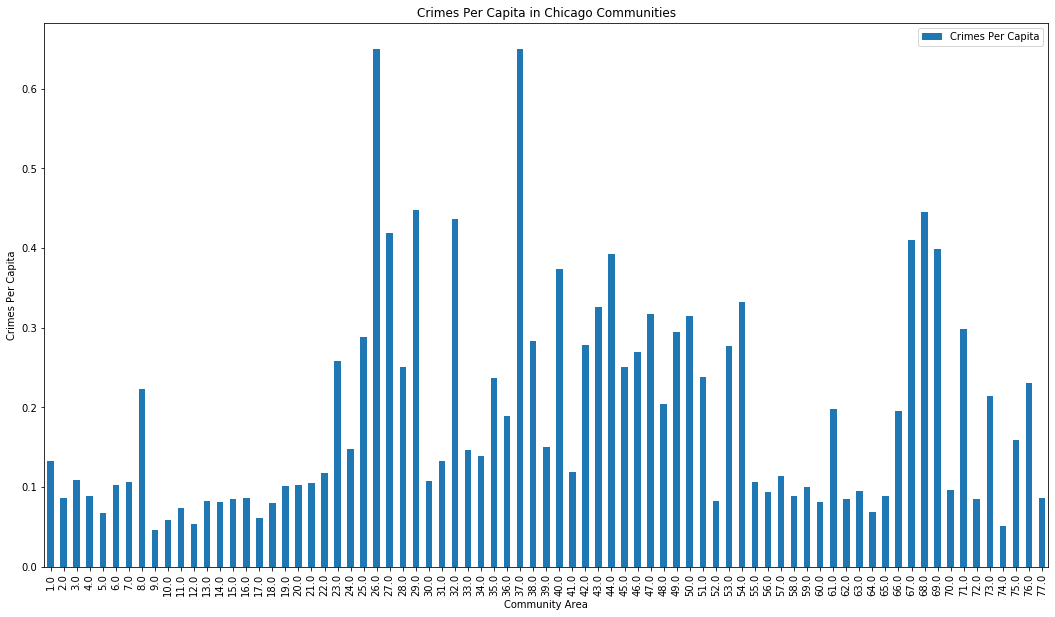

In [187]:
df_CrimeFinal.plot(x = "Community Area", y = "Crimes Per Capita", kind = "bar", figsize=(18, 10))
plt.ylabel('Crimes Per Capita') 
plt.title('Crimes Per Capita in Chicago Communities') 
plt.show()

Add the Crimes Per Capita information to the original df_Community dataframe and sort a new dataframe based on Crimes Per Capita

In [265]:
df_Community['Crimes Per Capita']=df_CrimeFinal['Crimes Per Capita']

In [266]:
df_crimesort = df_Community.sort_values(by='Crimes Per Capita').reset_index(drop=True)
df_crimesort

,Number,Community,Latitude,Longitude,Crimes Per Capita
0,9,EDISON PARK,42.002484,-87.818219,0.045842
1,74,MOUNT GREENWOOD,41.698243,-87.705408,0.050993
2,12,FOREST GLEN,41.978588,-87.751935,0.053263
3,10,NORWOOD PARK,41.988066,-87.802749,0.058670
4,17,DUNNING,41.952809,-87.796449,0.061549
...,...,...,...,...,...
72,32,LOOP,41.881609,-87.629457,0.436622
73,68,ENGLEWOOD,41.779802,-87.628245,0.445304
74,29,NORTH LAWNDALE,41.860032,-87.718388,0.447464
75,37,FULLER PARK,41.811377,-87.634645,0.649446


#### Mark the communities on the map by dividing them into three groups from least (green) to medium (yellow) to highest (red) crimes per capita

In [271]:
map_chicago = folium.Map(location=[latitude, longitude], zoom_start=10)
count = 1

# add markers to map
for lat, lng, community, crimepercapita in zip(df_crimesort['Latitude'], df_crimesort['Longitude'], df_crimesort['Community'],
                                              df_crimesort['Crimes Per Capita']):
    
    if count <= 26:
        col = 'green'
        fcol = 'green'
    elif count > 26 and count <= 52:
        col = 'yellow'
        fcol = 'yellow'
    elif count > 52:
        col = 'red'
        fcol = 'red'

    label = '{},{}'.format(community, crimepercapita)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=col,
        fill=True,
        fill_color=fcol,
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
    count = count + 1
    
map_chicago

### Explore Chicago Communities

Specify credentials for the Foursquare API

In [ ]:
CLIENT_ID = '******'
CLIENT_SECRET = '******'
VERSION = '20180605'
LIMIT = 100

Function to extract and store venues within a radius given geospatial coordinates of a community

In [350]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Community', 
                  'Community Latitude', 
                  'Community Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Extract chicago community venues using Foursquare API

In [ ]:
chicago_venues = getNearbyVenues(names=df_Community['Community'],
                                   latitudes=df_Community['Latitude'],
                                   longitudes=df_Community['Longitude']
                                  )

Inpect the new dataframe containing venue information from all chicago communities

In [352]:
print(chicago_venues.shape)
chicago_venues.head()

(1523, 7)


,Community,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ROGERS PARK,42.009574,-87.67555,El Famous Burrito,42.010421,-87.674204,Mexican Restaurant
1,ROGERS PARK,42.009574,-87.67555,Bark Place,42.010080,-87.675223,Pet Store
2,ROGERS PARK,42.009574,-87.67555,Taqueria & Restaurant Cd. Hidalgo,42.011634,-87.674484,Mexican Restaurant
3,ROGERS PARK,42.009574,-87.67555,Nueva Italy Pizzeria,42.011629,-87.674205,Pizza Place
4,ROGERS PARK,42.009574,-87.67555,Panaderia Ayutla,42.008405,-87.673536,Bakery


Inspect total venue counts per community

In [353]:
chicago_venues.groupby('Community').count()

,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Community,,,,,,
ALBANY PARK,39,39,39,39,39,39
ARCHER HEIGHTS,8,8,8,8,8,8
ARMOUR SQUARE,13,13,13,13,13,13
ASHBURN,4,4,4,4,4,4
AUBURN GRESHAM,10,10,10,10,10,10
AUSTIN,13,13,13,13,13,13
AVALON PARK,3,3,3,3,3,3
AVONDALE,5,5,5,5,5,5
BELMONT CRAGIN,10,10,10,10,10,10


In [354]:
print('There are {} uniques categories.'.format(len(chicago_venues['Venue Category'].unique())))

There are 267 uniques categories.


Create a new dataframe with one hot encoding considering all the venue categories

In [355]:
# one hot encoding
chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix="", prefix_sep="")

# add community column back to dataframe
chicago_onehot['Community'] = chicago_venues['Community'] 

# move community column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]

chicago_onehot.head()

,Community,ATM,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arcade,...,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,ROGERS PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ROGERS PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ROGERS PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ROGERS PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ROGERS PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [356]:
chicago_onehot.shape

(1523, 268)

Create a new dataframe that groups all venues per Community and calculates the mean occurence of each venue

In [357]:
chicago_grouped = chicago_onehot.groupby('Community').mean().reset_index()
chicago_grouped

,Community,ATM,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arcade,...,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,ALBANY PARK,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.025641,0.000000
1,ARCHER HEIGHTS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,ARMOUR SQUARE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,ASHBURN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,AUBURN GRESHAM,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
5,AUSTIN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.076923,0.000000
6,AVALON PARK,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
7,AVONDALE,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,...,0.2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
8,BELMONT CRAGIN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
9,BEVERLY,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [358]:
chicago_grouped.shape

(75, 268)

Display the top 10 most common venues per category

In [360]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [361]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Community']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
community_venues_sorted = pd.DataFrame(columns=columns)
community_venues_sorted['Community'] = chicago_grouped['Community']

for ind in np.arange(chicago_grouped.shape[0]):
    community_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

community_venues_sorted.head()

,Community,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALBANY PARK,Mexican Restaurant,Hookah Bar,Coffee Shop,Bank,Pizza Place,Cosmetics Shop,Discount Store,Thai Restaurant,Dive Bar,Sandwich Place
1,ARCHER HEIGHTS,Mexican Restaurant,Grocery Store,Construction & Landscaping,Park,Flower Shop,Bar,Restaurant,Electronics Store,Donut Shop,Dry Cleaner
2,ARMOUR SQUARE,Chinese Restaurant,Café,Gas Station,Sandwich Place,Cosmetics Shop,Hot Dog Joint,Italian Restaurant,Ice Cream Shop,Grocery Store,Asian Restaurant
3,ASHBURN,Automotive Shop,Light Rail Station,Food,Cosmetics Shop,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service
4,AUBURN GRESHAM,Intersection,Fast Food Restaurant,Pharmacy,Sandwich Place,Bar,American Restaurant,Seafood Restaurant,Caribbean Restaurant,Chinese Restaurant,Dry Cleaner


#### Use kmeans clustering to group communities based on their similarities with respect to the available venues

In [362]:
# set number of clusters
kclusters = 5

chicago_grouped_clustering = chicago_grouped.drop('Community', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chicago_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 0, 3, 1, 3, 3, 2, 1, 3, 3])

Merge the original chicago community data with the cluster labels and most common venues

In [363]:
# add clustering labels
community_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chicago_merged = df_Community

# merge chicago_grouped with df_Chicago to add latitude/longitude for each community
chicago_merged = chicago_merged.join(community_venues_sorted.set_index('Community'), on='Community')

chicago_merged.head() # check the last columns!

,Number,Community,Latitude,Longitude,Crimes Per Capita,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,ROGERS PARK,42.009574,-87.675550,0.132832,3.0,Mexican Restaurant,Chinese Restaurant,Pizza Place,Sandwich Place,Park,Rental Car Location,Bakery,Deli / Bodega,Bus Station,Playground
1,2,WEST RIDGE,42.003548,-87.696243,0.085928,1.0,Paper / Office Supplies Store,Electronics Store,Fried Chicken Joint,Convenience Store,Insurance Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Yoga Studio
2,3,UPTOWN,41.969450,-87.660513,0.108257,3.0,Vietnamese Restaurant,Pizza Place,Chinese Restaurant,Thai Restaurant,Coffee Shop,Sushi Restaurant,Music Venue,Bagel Shop,Fried Chicken Joint,Bakery
3,4,LINCOLN SQUARE,41.968512,-87.688653,0.088074,3.0,Bar,Thai Restaurant,Café,Coffee Shop,Pizza Place,Sushi Restaurant,Chinese Restaurant,Sandwich Place,Pub,Art Gallery
4,5,NORTH CENTER,41.956107,-87.679160,0.067535,3.0,Bar,Boutique,Coffee Shop,Brewery,Dive Bar,Bank,Gym,Gym / Fitness Center,Bus Station,Video Store


In [365]:
community_venues_sorted.set_index('Community')

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Community,,,,,,,,,,,
ALBANY PARK,3,Mexican Restaurant,Hookah Bar,Coffee Shop,Bank,Pizza Place,Cosmetics Shop,Discount Store,Thai Restaurant,Dive Bar,Sandwich Place
ARCHER HEIGHTS,0,Mexican Restaurant,Grocery Store,Construction & Landscaping,Park,Flower Shop,Bar,Restaurant,Electronics Store,Donut Shop,Dry Cleaner
ARMOUR SQUARE,3,Chinese Restaurant,Café,Gas Station,Sandwich Place,Cosmetics Shop,Hot Dog Joint,Italian Restaurant,Ice Cream Shop,Grocery Store,Asian Restaurant
ASHBURN,1,Automotive Shop,Light Rail Station,Food,Cosmetics Shop,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service
AUBURN GRESHAM,3,Intersection,Fast Food Restaurant,Pharmacy,Sandwich Place,Bar,American Restaurant,Seafood Restaurant,Caribbean Restaurant,Chinese Restaurant,Dry Cleaner
AUSTIN,3,Bus Station,Park,Wings Joint,Construction & Landscaping,Gym,Grocery Store,Donut Shop,Intersection,Train Station,Liquor Store
AVALON PARK,2,Athletics & Sports,Park,Train Station,Electronics Store,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant
AVONDALE,1,Food,Veterinarian,American Restaurant,Dive Bar,Falafel Restaurant,Factory,Farm,Fabric Shop,Eye Doctor,Discount Store
BELMONT CRAGIN,3,South American Restaurant,Currency Exchange,Mexican Restaurant,Latin American Restaurant,Bakery,Automotive Shop,Café,Chinese Restaurant,Pharmacy,Cultural Center


#### Redraw the map with community markers showing the 5 community clusters obtained using Kmeans clustering

In [366]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['Community'], chicago_merged['Cluster Labels']):
    try:
        int(cluster)
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster)-1],
            fill=True,
            fill_color=rainbow[int(cluster)-1],
            fill_opacity=0.7).add_to(map_clusters)        
    except:
        continue
       
map_clusters

#### Cluster 1

In [367]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 0, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,Community,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,LOWER WEST SIDE,0.0,Mexican Restaurant,Pizza Place,Breakfast Spot,Thrift / Vintage Store,Bakery,Coffee Shop,Bank,Music Venue,Fried Chicken Joint,Discount Store
45,SOUTH CHICAGO,0.0,Mexican Restaurant,Park,Convenience Store,Italian Restaurant,Bakery,Dessert Shop,Train Station,Shoe Store,Discount Store,Eye Doctor
50,SOUTH DEERING,0.0,Mexican Restaurant,Bar,Yoga Studio,Event Service,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Eye Doctor
56,ARCHER HEIGHTS,0.0,Mexican Restaurant,Grocery Store,Construction & Landscaping,Park,Flower Shop,Bar,Restaurant,Electronics Store,Donut Shop,Dry Cleaner
61,WEST ELSDON,0.0,Mexican Restaurant,Gas Station,Video Store,Bar,Supermarket,Ice Cream Shop,Flower Shop,Grocery Store,American Restaurant,Fast Food Restaurant


#### Cluster 2

In [368]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 1, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,Community,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,WEST RIDGE,1.0,Paper / Office Supplies Store,Electronics Store,Fried Chicken Joint,Convenience Store,Insurance Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Yoga Studio
20,AVONDALE,1.0,Food,Veterinarian,American Restaurant,Dive Bar,Falafel Restaurant,Factory,Farm,Fabric Shop,Eye Doctor,Discount Store
28,NORTH LAWNDALE,1.0,BBQ Joint,Concert Hall,Food,Convenience Store,Yoga Studio,Ethiopian Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store
46,BURNSIDE,1.0,Southern / Soul Food Restaurant,Intersection,Convenience Store,Food,Gym,Liquor Store,Ethiopian Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant
57,BRIGHTON PARK,1.0,Chinese Restaurant,Arts & Entertainment,Factory,Convenience Store,Park,Hot Dog Joint,Food,Sandwich Place,Basketball Court,Intersection
63,CLEARING,1.0,Food,Deli / Bodega,Heliport,Airport,Airport Service,Airport Terminal,Sports Bar,Bank,Currency Exchange,Nightclub
69,ASHBURN,1.0,Automotive Shop,Light Rail Station,Food,Cosmetics Shop,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service


#### Cluster 3

In [369]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 2, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,Community,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,NORWOOD PARK,2.0,Park,Clothing Store,Dog Run,Diner,Hobby Shop,Fabric Shop,Factory,Eye Doctor,Event Service,Falafel Restaurant
35,OAKLAND,2.0,Park,Lake,Public Art,Bus Stop,Yoga Studio,Eastern European Restaurant,Dive Bar,Dog Run,Donut Shop,Dry Cleaner
36,FULLER PARK,2.0,Baseball Field,Park,Fast Food Restaurant,Restaurant,Food,Bus Station,Train Station,Dog Run,Donut Shop,Dry Cleaner
39,WASHINGTON PARK,2.0,Gas Station,Park,Nature Preserve,Bus Station,Fabric Shop,Eye Doctor,Event Service,Factory,Discount Store,Electronics Store
44,AVALON PARK,2.0,Athletics & Sports,Park,Train Station,Electronics Store,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant
72,WASHINGTON HEIGHTS,2.0,Salon / Barbershop,Caribbean Restaurant,American Restaurant,Park,Cosmetics Shop,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant
73,MOUNT GREENWOOD,2.0,Park,Home Service,Mexican Restaurant,Cosmetics Shop,Yoga Studio,Event Service,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store


#### Cluster 4

In [370]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 3, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,Community,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ROGERS PARK,3.0,Mexican Restaurant,Chinese Restaurant,Pizza Place,Sandwich Place,Park,Rental Car Location,Bakery,Deli / Bodega,Bus Station,Playground
2,UPTOWN,3.0,Vietnamese Restaurant,Pizza Place,Chinese Restaurant,Thai Restaurant,Coffee Shop,Sushi Restaurant,Music Venue,Bagel Shop,Fried Chicken Joint,Bakery
3,LINCOLN SQUARE,3.0,Bar,Thai Restaurant,Café,Coffee Shop,Pizza Place,Sushi Restaurant,Chinese Restaurant,Sandwich Place,Pub,Art Gallery
4,NORTH CENTER,3.0,Bar,Boutique,Coffee Shop,Brewery,Dive Bar,Bank,Gym,Gym / Fitness Center,Bus Station,Video Store
5,LAKE VIEW,3.0,Gay Bar,Sandwich Place,Mexican Restaurant,General Entertainment,Japanese Restaurant,Baseball Stadium,Taco Place,Outdoor Sculpture,Coffee Shop,New American Restaurant
6,LINCOLN PARK,3.0,Harbor / Marina,Boat or Ferry,Bus Station,Assisted Living,Gym,Lake,Public Art,Roof Deck,Playground,Park
7,NEAR NORTH SIDE,3.0,Italian Restaurant,Steakhouse,Bar,American Restaurant,Hotel,Coffee Shop,Mexican Restaurant,Seafood Restaurant,Gym,Gym / Fitness Center
8,EDISON PARK,3.0,Italian Restaurant,Bar,Park,Theater,Cosmetics Shop,Salon / Barbershop,Deli / Bodega,Pub,French Restaurant,Seafood Restaurant
10,JEFFERSON PARK,3.0,Bar,Theater,Pharmacy,Bakery,Sushi Restaurant,Filipino Restaurant,Liquor Store,Marijuana Dispensary,Sandwich Place,Eastern European Restaurant
11,FOREST GLEN,3.0,Pizza Place,Light Rail Station,Moving Target,Tailor Shop,BBQ Joint,Taco Place,Asian Restaurant,Dance Studio,Bar,Train Station


#### Cluster 5

In [371]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 4, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,Community,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,ROSELAND,4.0,Sandwich Place,Yoga Studio,Farm,Falafel Restaurant,Factory,Fabric Shop,Eye Doctor,Event Service,Ethiopian Restaurant,Electronics Store


## Discussion

The section on 'Analyzing Crime in Chicago Communities' used public data from 2020 and 2019 to calculate the crime per capita. However, the population data used in this study is from 2017. The calculation of crime per capita therefore, may not be completely accurate. Also, it's important to note that Chicago is a very popular tourist spot and therefore, crime per capita may not necessarily be a good indicator of crime rate especially in communities which are attractive tourist centers. This is because regions such as the Loop i.e. Downtown Chicago might have higher foot-traffic every year compared to actual registered residents. The total 'true' crime per capita in these communities might be lower when comparing with just the residents.

That said, the current analysis shows that communities in the north east and south west of downtown chicago (Loop) have lower crime rates compared to the communities on the west and the south.

The section on 'Exploring Chicago Communities' does not take into account the results of the study from the 'Analyzing Crime in Chicago Communities' section for the reasons discussed above. However, one can easily narrow down the scope of exploring the venues by considering only the communities with lower crime rates. Alternatively, one can also use the crime rate information after a certain community cluster has been deemed favorable based on the amenities they offer.

Based on the results obtained from Kmean clustering, it's evident that Cluster 1 is quite popular for Mexican restaurants. Cluster 2 offers several convenience and general stores, grocery and other shops. Communities in Cluster 2, therefore, might be prefered by families planning to move to Chicago. Cluster 3 contains communities with more outdoor recreational ameneties like parks and lakes. Cluster 4 might be preferred by someone who wants a close proximity to various restaurants and bars as well easy access to public transportation. Cluster 5 contains just one entry and therefore, it not does not provide any conclusive information.

## Conclusion

This study is aimed at assiting those who want to make an informed data-driven decision when deciding which community to choose when moving to Chicago. After mapping all the 77 communities in Chicago, communities were classified based on the crime rate per capita. This analysis will help is choosing safer communities. Machine Learning technique was then used to cluster communities based on the amenities they offer such as restaurants, shops, transportation etc. This analysis will help to identify communities based on individual preferences - whether it's proximity to parks or restaurants and bars or public transportation etc.

In the future, this study can be enhanced by incorporating information about real estate prices and also other aspects such as promity to schools, traffic information etc.